# Scaling collpase cleaned

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import numpy.ma as ma
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [227]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID']*data[i]['rsquared'] for i in range(len(Ws))])
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID

ID8 = load_IDs(8, range(0,10000))
ID10 = load_IDs(10, range(0,1000))
ID12 = load_IDs(12, range(0,1000))
ID14 = load_IDs(14, range(0,1000))

Loaded 10000 out of 10000 seeds
Loaded 1000 out of 1000 seeds
Loaded 1000 out of 1000 seeds
Loaded 1000 out of 1000 seeds


In [285]:
def load_data(rho, Ls= np.arange(8,16,2).astype(float), skip_initial=5):
    
    Y = np.zeros((len(Ls),len(rho)))
    dY = np.zeros((len(Ls),len(rho)))
    for index, L in enumerate(Ls):
        data = np.load('data/cluster/'+'2nn-{}-combined.npy'.format(int(L)))
        Y[index] = np.mean(data,axis=0)
        dY[index] = np.std(data,axis=0)

    rho = rho[skip_initial:]
    Y = Y[:,skip_initial:]
    dY = dY[:,skip_initial:]
    return rho, Y, dY

def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)



def ff(a,b):
    d = {True:1, False:-1}
    return d[a<b]

ff = np.vectorize(ff)

def x_BKT(rho, rho_c, l, alpha):
    #sign=ff(rho[0], rho_c)
    #sign=1
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2, 1.4]):
    rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]
    
    x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
    return quality(x,y,dy)
    
def scaledata(l, rho, a, da, rho_c, nu, zeta, alpha):
    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    '''x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old'''
    #x = l_mesh*np.exp(-1.4/np.sqrt(abs(rho_mesh-rho_c)))  ### This 1.4 is taking from mendes santos :/
    x = x_BKT(rho_mesh, rho_c,l_mesh,alpha)
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return x, y, dy

def autoscale(l, rho, a, da, rho_c0, nu0, zeta0, alpha0, x_bounds=None, **kwargs):
    

    ret = minimize(
        goal_function,
        [rho_c0, nu0, zeta0,alpha0],
        method='Nelder-Mead',
        options={
            'xtol': 1e-3,
            'ftol': 1e-3,
        }
    )

    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']

    return ret
def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm
    This is a helper function and not supposed to be called directly.
    Parameters
    ----------
    sim : ndarray
        the final simplex
    fsim : ndarray
        the function values at the vertices of the final simplex
    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco

In [286]:
rho = np.linspace(0.1,6.1,31)
rho, a, da = load_data(rho)
l = [8,10,12,14]

In [287]:
rho = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])
a = np.vstack([ma.mean(ID, axis=0) for ID in [ID8,ID10,ID12,ID14]])
da = np.vstack([ma.std(ID, axis=0) for ID in [ID8,ID10,ID12,ID14]])


start,stop = 8,47
a, da, rho = a[:,start:stop],da[:,start:stop],rho[start:stop]
rho

array([2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 ,
       3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65,
       3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 ,
       4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ])

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-285-a23b9b34b87e>:29: RuntimeWarning: divide by zero encountered in true_divide
  return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))
100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s]


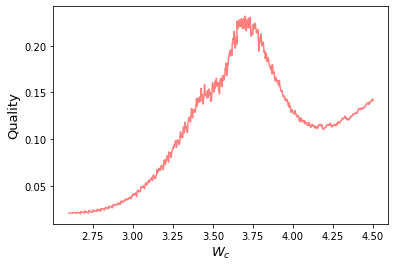

In [288]:
out = []
rs = np.linspace(min(rho),max(rho),1000)
for r in tqdm(rs):
    out.append(goal_function([r,2,2,1.5]))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.show()

In [289]:
ret = autoscale(l, rho, a, da, 3.6,2.,2., 1.4)
ret

         alpha: 1.5622444945263807
        dalpha: 2.6947112710779417
           dnu: 1.8291252626113246
          drho: 4.432781705765539
         dzeta: 0.6491595358372648
        errors: array([4.43278171, 1.82912526, 0.64915954, 2.69471127])
 final_simplex: (array([[2.67416258, 2.1948518 , 2.10670594, 1.56224449],
       [2.67959489, 2.19316   , 2.10619799, 1.56179177],
       [2.67804339, 2.19488619, 2.10481756, 1.56043031],
       [2.67802792, 2.19329293, 2.10568996, 1.56296764],
       [2.6771501 , 2.1949304 , 2.10620232, 1.56122938]]), array([0.01776542, 0.01910777, 0.01930484, 0.01932637, 0.01960717]))
           fun: 0.01776541615976545
       message: 'Optimization terminated successfully.'
          nfev: 71
           nit: 31
            nu: 2.194851797339062
           rho: 2.6741625782612273
        status: 0
       success: True
         varco: array([[ 19.64955365,   7.76652042,  -1.75240642, -11.75619497],
       [  7.76652042,   3.34569923,  -0.47223963,  -4.8520727 

In [290]:
x, y, dy = scaledata(l, rho, a, da, ret['rho'], ret['nu'], ret['zeta'], ret['alpha'])

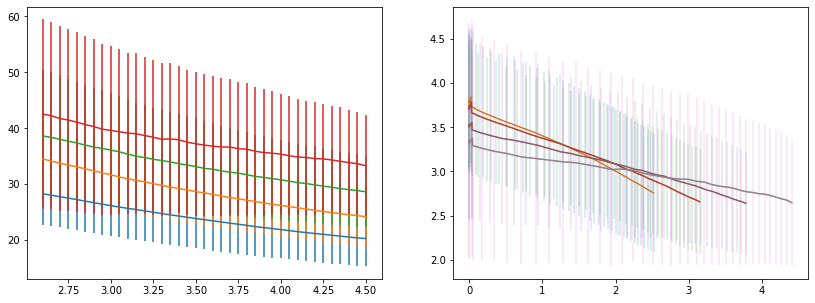

In [295]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

for i,j,k in zip(np.vstack([rho,rho,rho,rho]),a,da):
    ax[0].errorbar(i,j, yerr=k)    

for i,j,k in zip(x,y,dy):
    ax[1].errorbar(i,j, yerr=k, lw=.3)
    ax[1].plot(i,j)
#ax[1].set_xlim(0,100)